# halo EFT 

$n-\alpha$ scattering calculation from __C.A. Bertulani et al. NPA712(2002)37-58__

 $p_{1/2}$ non-resonant
 
 $p_{3/2}$ -> resonance at E~1 MeV, shallow virtual bound state
  This requires new power counting.           
 
 $s_{1/2}$ non-resonant
 

In [110]:
import numpy
import numpy as np

import matplotlib.pyplot as plt

import scipy 
import scipy.special
from scipy.special import factorial

from sympy.physics.sho import E_nl
from sympy import symbols
from sympy.physics.sho import R_nl
from sympy import var
from sympy.physics.wigner import wigner_9j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import clebsch_gordan

from functools import lru_cache

hbarc = 197.326968 # MeV.fm 
amu = 931.4940954 # MeV
mass_p  = 938.272    
mass_n  = 939.5653
mass_N = (mass_p+mass_n)/2.0
alpha = 1.0/137.035

mass_alpha = 3727.4 # MeV 

reduced_mass = mass_n*mass_alpha/(mass_n+mass_alpha)
fm = 1/hbarc # MeV^-1 

## ERE of Table 1.

ERE of n-alpha is already known as Table 1.  

The power counting scale estimation in the text below table 1.
(Be careful for the units)

In [75]:
#----------ERE data
ERE_data={'0+': [2.4641*fm, 1.385*fm,0.0], '1-':[-13.821*fm**3,-0.419*fm**(-1),0.0],'1+':[-62.951*fm**3,-0.8819*fm**(-1),-3.002*fm]}

# scale estimation
print('**M_{lo} and M_{hi} estimation (MeV) from ERE ')
print('1+ channel = ', 1/(-ERE_data['1+'][0])**(1./3), 1/(-ERE_data['1+'][1]/2)**(-1), 1/(-ERE_data['1+'][2]/4)  )

print('0+ channel = ',1/(ERE_data['0+'][0]), 1/(ERE_data['0+'][1]/2) )

print('1- channel = ',1/(-ERE_data['1-'][0])**(1/3), 1/(-ERE_data['1-'][1]/2)**(-1) )


**M_{lo} and M_{hi} estimation (MeV) from ERE 
1+ channel =  49.60425122682985 87.0113265396 262.92733910726184
0+ channel =  80.08074672294143 284.94869025270754
1- channel =  82.22551845682871 41.339999795999994


## Phase shift of 1+ channel Fig. 4
Phase shift extracted as eq.(24)

$ \delta_{l} = \frac{1}{2 i}\log (1+2ik*f_l) $

where $f_{l}$ partial wave scattering amplitudes  eq.(30)

LO amplitudes from eq.(46) , NLO amplitudes from eq.(49)

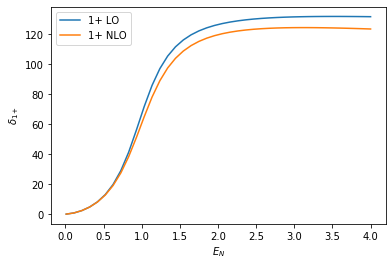

In [87]:
# 1+ phase shift 
a = ERE_data['1+'][0]  # to MeV units
r = ERE_data['1+'][1]     # to MeV units
P = ERE_data['1+'][2]     # to MeV units   

# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{1+} )
f_LO = k_list**2/(-1./a+r/2*k_list**2-1j*k_list**3)
f_NLO= P1p/4.0*k_list**6/(-1./a+r/2*k_list**2-1j*k_list**3)**2

# LO phase shift
temp=1+2*1j*k_list*f_LO
delta = np.log(temp)/(2*1j)*180/np.pi 
for i in range(len(delta)):
    if delta[i]<0:
        delta[i]=delta[i]+180
delta_LO = delta

#NLO phase shift
temp=1+2*1j*k_list*(f_LO+f_NLO)
delta = np.log(temp)/(2*1j)*180/np.pi 
for i in range(len(delta)):
    if delta[i]<0:
        delta[i]=delta[i]+180
delta_NLO = delta
        
# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_LO),label='1+ LO' )
plt.plot(E_lab,np.real(delta_NLO),label='1+ NLO')
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{1+}$')
plt.legend()

## poles of 1+ channel at LO
eq.(23)

In [106]:
# 1+ 
a = ERE_data['1+'][0]  # to MeV units
r = ERE_data['1+'][1]     # to MeV units
P = ERE_data['1+'][2]     # to MeV units   

# pole positions 
a1=abs(a); r1=abs(r) ;

v = (108+a1*r1**3+108*np.sqrt(1+a1*(r1**3)/54))**(1./3)

gamma_1= (r1+a1**(1/3.)*r1**2/v+v/a1**(1./3) )/6.
gamma = (r1-a1**(1/3.)*r1**2/(2*v)-v/(2*a1**(1./3)) )/6.
gamma_t = -np.sqrt(3)/12*(a1**(1./3)*r1**2/v-v/a1**(1./3))
print('gamma_1=%f gamma=%f gamma_t=%f'%(gamma_1,gamma,gamma_t))

E0 = (gamma**2+gamma_t**2)/(2*reduced_mass)
Gamma = -4*gamma*np.sqrt(E0/(2*reduced_mass) )
print('E0=%f  Gamma(E0)=%f'%(E0,Gamma))

gamma_1=99.371692 gamma=-6.180183 gamma_t=34.497475
E0=0.818400  Gamma(E0)=0.577271


## Phase shift 0+ channel Fig.5

Problem? At first, eq.(47) implies that f_{NLO}=-a  for 0+ channel.

However, the phase shift plot corresponds to f_{NLO}=1/(-1/a - i k) 


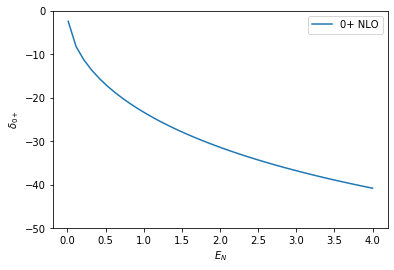

In [102]:
# 1+ phase shift 
a = ERE_data['0+'][0]  
r = ERE_data['0+'][1]  
P = ERE_data['0+'][2]  
# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{0+} )
#f_LO = 0.0
#f_NLO= -a

f_LO =0.0
f_NLO= 1/(-1/a-1j*k_list)

#f_LO =0.0
#f_NLO= -a*(1-1j*a*k_list)

#NLO phase shift
temp=1+2*1j*k_list*(f_LO+f_NLO)
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_NLO = delta
        
# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_NLO),label='0+ NLO')
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{0+}$')
plt.ylim([-50,0])
plt.legend()

## Phase shift 1- channel Fig. 8


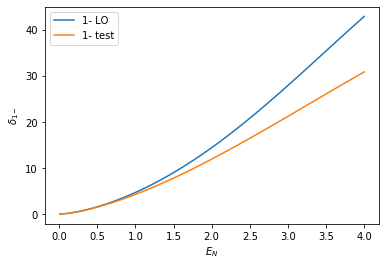

In [108]:
# 1+ phase shift 
a = ERE_data['1-'][0]  # to MeV units
r = ERE_data['1-'][1]     # to MeV units
P = ERE_data['1-'][2]     # to MeV units   

# in lab frame energy 
E_lab = np.linspace(0.01,4,40) 
E_cm =  reduced_mass/mass_n*E_lab
k_list = np.sqrt(2*reduced_mass*E_cm)

# scattering Amplitudes ( f_{1-} ) in modified power counting 
f_LO = k_list**2/(-1./a+r/2*k_list**2-1j*k_list**3)

# LO phase shift
temp=1+2*1j*k_list*f_LO
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_LO = delta


# scattering Amplitudes ( f_{1-} ) in modified power counting 
f_test = k_list**2/(-1./a-1j*k_list**3)

# LO phase shift
temp=1+2*1j*k_list*f_test
delta = np.log(temp)/(2*1j)*180/np.pi 
delta_test = delta

# plot as a function of neutron kinetic energy vs pahse shift 
plt.plot(E_lab,np.real(delta_LO),label='1- LO' )
plt.plot(E_lab,np.real(delta_test),label='1- test' )
plt.xlabel(r'$E_N$')
plt.ylabel(r'$\delta_{1-}$')
plt.legend()

## Differential cross section Fig.7

Using general formula in the note 

__Be careful for the notation of scipy for clebsch-gordan and spherical harmonics !!__

In [192]:
def scattering_amp(m,mp,theta,kcm):
    """
    n+alpha scattering amplitude
    
    Be careful that output is fm units  
    """
    # scattering Amplitudes f[L,J]
    f={}
    # 1+ channel amplitude 
    (a,r,P) = ERE_data['1+']
    f[1,1.5] = kcm**2/(-1./a+r/2*kcm**2-1j*kcm**3)+P1p/4.0*kcm**6/(-1./a+r/2*kcm**2-1j*kcm**3)**2
    # 1- channel 
    (a,r,P) = ERE_data['1-']
    f[1,0.5] = kcm**2/(-1./a+r/2*kcm**2-1j*kcm**3)
    # 0+ channel
    (a,r,P) = ERE_data['0+']
    f[0,0.5] = 1/(-1./a-1j*kcm)
    # sum over L,M,J
    sums =0.0
    for J in np.arange(0.5,1.5+1):
        for L in np.arange(0,1+1):
            factor = np.sqrt(4*np.pi*(2*L+1))*float(clebsch_gordan(L,0.5,J, 0,m,m))*float(clebsch_gordan(L,0.5,J, m-mp,mp,m))
            if abs(factor)>1.e-24:
                sums = sums + factor*scipy.special.sph_harm(m-mp,L, 0,theta)*f[L,J]
                #print(factor,scipy.special.sph_harm(m-mp,L,theta, 0),f[L,J]  )
    return sums*hbarc  #unit conversion             
                
def unpol_diff_cs(theta,kcm):
    """unpolarized differential cross section
       in unit of fm^2 
    """
    sums=0.0
    for m in [-0.5,0.5]:
        for mp in [-0.5,0.5]:
            sums = sums + np.abs(scattering_amp(m,mp,theta,kcm))**2
    return sums/2.0        
    

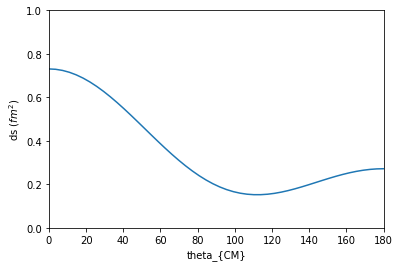

In [196]:
kcm=49.6 ;
thetaCM=np.linspace(0.0,np.pi,50)
ds=np.zeros(len(thetaCM))
for i in range(len(thetaCM)):
    ds[i]=unpol_diff_cs(thetaCM[i],kcm)
    
plt.plot(thetaCM*180/np.pi,ds/100.)   #into barn unit
plt.xlabel(r'theta_{CM}')
plt.ylabel(r'ds ($fm^2$)')
plt.ylim([0,1]);
plt.xlim([0,180]);